In [1]:
import csv
import time
import string
import numpy as np
import pandas as pd
import torch as pt
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output
from transformers import GPT2ForSequenceClassification, ReformerModelWithLMHead, get_linear_schedule_with_warmup
from pytorch_transformers import GPT2Tokenizer
from Learning import *
device = pt.device("cuda" if pt.cuda.is_available() else "cpu")

[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Complete.


In [2]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2-large")

In [3]:
cats, cats_sing, phrases = Listset().load()  # Import word lists dataset

In [4]:
tokenizer.encode("A list of round fruits: apples, oranges, pears,"), \
    tokenizer.encode("A list of round fruits: apples,"), \
    tokenizer.encode("oranges, pears,")

([317, 1351, 286, 2835, 15921, 25, 22514, 11, 48389, 11, 279, 4127, 11],
 [317, 1351, 286, 2835, 15921, 25, 22514, 11],
 [48389, 11, 279, 4127, 11])

In [5]:
   ###   Options   ###

model_name = "ernst_one"             # First, use a mean pooling of the claim and chained evidence
test_set_frac = 0.25                 # Fraction of samples to keep as separate test set  (list sets)
sample_test_n = 25                   # Number of randomly generated prompts for each sample when testing model
log_period_batches = 25              # Batches per iteration
learning_rate = 5e-5                 # Adam learning rate (default is 5e-5, sentiment classification example had 2e-5)
adam_epsilon = 1e-8                  # Adam epsilon (default is 1e-8)
n_sched_warmup = 0                   # Linear scheduler for optimizer number of warmup steps
batch_size = bsz = 2                 # Samples per batch
N_train_batches = int(1e7 / bsz)     # Total number of batches to show model
min_nw, max_nw = 0.17, 0.8           # Minimum and maximum fraction of list to keep when truncating
max_listlen = 10                     # Maximum number of words in the list when creating a prompt (at least prior to * max_nw)
lidstone_e = 0.0                     # Smoothing for possible words/subwords which are not in the missing list words set

In [6]:
lprompts_encoded = [(tokenizer.encode(prompt), "types of" in prompt) for prompt in lprompts]
cats_e = [[tokenizer.encode(c + ': ') for c in cs] for cs in cats]
cats_sing_e = [[tokenizer.encode(c + ': ') for c in cs] for cs in cats_sing]
phrases_e = [[tokenizer.encode(p + ', ') for p in ps] for ps in phrases]
N_tokens = len(tokenizer)
N_wordlists = len(cats)

In [7]:
# Generate a fixed test set and save to disk, using nw_draw = 15. This function defines the next list token prediction problem
def gen_truncated_list(prmt, p):  # prmt = prompt tokens, p = list phrases tokens list
    tkzs, sent, tkix = [], [], 0
    incl_words = np.random.choice(len(p), min(max_listlen, len(p)), replace=False)
    for phz_i in incl_words:
        phz_enc = p[phz_i]
        tkzs.append((tkix, phz_enc))
        tkix += len(phz_enc)
        sent += phz_enc
    missing_w = [p[i] for i in range(len(p)) if i not in incl_words]
    trunc_ix = np.random.randint(round(tkix * min_nw), round(tkix * max_nw))
    trunc_n = min([(trunc_ix - ix) for (ix, enc) in tkzs if ix <= trunc_ix])  # N. end phrase tokens
    missing_w += [enc for (ix, enc) in tkzs if ix >= (trunc_ix - trunc_n)]
    missing_matches = missing_w
    if trunc_n > 0:
        phr_start = trunc_ix - trunc_n
        partial_phr = sent[phr_start:trunc_ix]
        missing_matches = [enc for enc in missing_w if enc[:trunc_n] == partial_phr]
    next_tokens = [enc[trunc_n] for enc in missing_matches]
    norm = len(next_tokens) * (1.0 + lidstone_e)
    tunit, y_ = 1 / norm, np.tile(lidstone_e / N_tokens, N_tokens)
    for token in next_tokens: y_[token] += tunit
    return np.hstack([prmt, sent[:trunc_ix]]), y_
def gen_samples_uniform(xcp, xcs, xp, nw, verbose=False):  # Weight testing samples (word lists) uniformly
    xs, ys, sqlens, j = [], [], [], 0
    for i in range(len(xcp)):
        x, y, sqlen = [], [], []
        cp, cs, p = xcp[i], xcs[i], xp[i]
        for m in range(nw):
            prmt, typesof = lprompts_encoded[np.random.randint(len(lprompts_encoded))]
            cat_ix = np.random.randint(len(cp))
            x_, y_ = gen_truncated_list(np.hstack([prmt, cp[cat_ix] if typesof else cs[cat_ix]]), p)
            x.append(x_)
            y.append(y_)
            sqlen.append(len(x_))
            j += 1
            if verbose and j % 100 == 0:
                sys_print("\rDone: " + str(j))
        xs.append(x)
        ys.append(y)
        sqlens.append(sqlen)
    if verbose: sys_print("\rDone: " + str(j) + ", finished!\n")
    return xs, ys, sqlens
def gen_samples(xcp, xcs, xp, n):  # Maximise training batch diversity by randomly sampling the word lists
    xs, ys, sqlens, j = [], [], [], 0
    n_sets = len(xcp)
    for m in range(n):
        i = np.random.randint(n_sets)
        cp, cs, p = xcp[i], xcs[i], xp[i]
        prmt, typesof = lprompts_encoded[np.random.randint(len(lprompts_encoded))]
        cat_ix = np.random.randint(len(cp))
        x_, y_ = gen_truncated_list(np.hstack([prmt, cp[cat_ix] if typesof else cs[cat_ix]]), p)
        xs.append(x_)
        ys.append(y_)
        sqlens.append(len(x_))
    return xs, ys, sqlens

In [8]:
N_test = int(test_set_frac * N_wordlists)
N_train = N_wordlists - N_test
# test_idx = np.random.choice(N_wordlists, N_test, replace=False)
test_idx = np.array([3, 7])
cats_e_test, cats_sing_e_test = [cats_e[i] for i in test_idx], [cats_sing_e[i] for i in test_idx]
phrases_e_test = [phrases_e[i] for i in test_idx]
train_idx = [i for i in range(N_wordlists) if i not in test_idx]
cats_e_train, cats_sing_e_train = [cats_e[i] for i in train_idx], [cats_sing_e[i] for i in train_idx]
phrases_e_train = [phrases_e[i] for i in train_idx]
test_cats = [cats[i][0] for i in test_idx]
test_xs, test_ys, test_sqlens = gen_samples_uniform(cats_e_test, cats_sing_e_test, phrases_e_test, sample_test_n, verbose=True)

Done: 50, finished!


In [9]:
save_ld((test_xs, test_ys, test_sqlens), "test.data")

In [10]:
# test_xs, test_ys, test_sqlens = load_ld("test.data")

In [11]:
# Define next batch function
def adapt_form(xs, ys, sqlens):
    max_len = max(sqlens)
    xs = pt.tensor(np.vstack([np.pad(x, (0, max_len - len(x)), constant_values=50256) for x in xs])).to(device)
    ys = pt.tensor(np.vstack(ys)).to(device)
    sqlens = pt.tensor(np.asarray(sqlens)).to(device)
    return xs, ys, sqlens
def next_batch(sz):
    global cats_e_train, cats_sing_e_train, phrases_e_train
    xs, ys, sqlens = gen_samples(cats_e_train, cats_sing_e_train, phrases_e_train, sz)
    return adapt_form(xs, ys, sqlens)

In [12]:
print(gc.collect())
create_folder("models")
create_folder("models/pretrained")
create_folder("models/pretrained/GPT2SeqClas")
model = GPT2ForSequenceClassification.from_pretrained('gpt2-large',
    output_hidden_states=True, output_attentions=True, 
    cache_dir="models/pretrained/GPT2SeqClas")
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id
n_embd = model.config.n_embd
model = nn.DataParallel(model, device_ids=list(range(pt.cuda.device_count()))).to(device)
print("GPT2 loaded")
gc.collect()

100


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2-large and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2 loaded


959

In [13]:
llayer = nn.Linear(n_embd, len(tokenizer), bias=False)
llayer = nn.DataParallel(llayer, device_ids=list(range(pt.cuda.device_count()))).to(device)
# softmax = nn.Softmax()
bcewl_loss = nn.BCEWithLogitsLoss()
# bcewl_loss = nn.DataParallel(bcewl_loss, device_ids=list(range(pt.cuda.device_count()))).to(device)
# nll_loss = nn.NLLLoss()
# kl_loss = nn.KLDivLoss()
optimizer = pt.optim.AdamW(model.parameters(), lr=learning_rate, eps=adam_epsilon)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=n_sched_warmup, num_training_steps=N_train_batches)
def train_step():
    global model, llayer, bcewl_loss, optimizer, scheduler
    x_batch, y_batch, sqlens_batch = next_batch(batch_size)
    x_batch, y_batch, sqlens_batch = x_batch.to(device), y_batch.to(device), sqlens_batch.to(device)
    
    model.zero_grad()
    outputs = model(x_batch.long())
    out_idx = pt.unsqueeze(pt.unsqueeze(sqlens_batch - 1, 1).repeat((1, n_embd)), 1).type(pt.int64)
    outs = pt.gather(outputs[2][-1], 1, out_idx).squeeze(1)
    logits = llayer(outs)
    
#     logsofts = pt.log(softmax(logits))
    loss = bcewl_loss(logits, y_batch.float())
    correct = pt.mean((y_batch[pt.arange(batch_size), pt.argmax(logits, axis=1)] > (lidstone_e / N_tokens)).float())
    loss_, correct_ = loss.detach().cpu().numpy(), correct.detach().cpu().numpy()
    
    loss.sum().backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()
    return loss_, correct_

def inference(x, sqlens):
    global model, llayer
    
    x, sqlens = x.to(device), sqlens.to(device)
    outputs = model(x.long())
    out_idx = pt.unsqueeze(pt.unsqueeze(sqlens - 1, 1).repeat((1, n_embd)), 1).type(pt.int64)
    outs = pt.gather(outputs[2][-1], 1, out_idx).squeeze(1)
    logits = llayer(outs)
    return logits
def eval_test(x, y, sqlens):
    global bcewl_loss
    
    with pt.no_grad():
        logits = inference(x, sqlens)
        loss = bcewl_loss(logits, y.float())
        correct = pt.mean((y[pt.arange(x.shape[0]), pt.argmax(logits, axis=1)] > (lidstone_e / N_tokens)).float())
        loss_, correct_ = loss.detach().cpu().numpy(), correct.detach().cpu().numpy()
    return loss_, correct_

# top_next = [self.tokenizer.decode(i.item()).strip() for i in probs.topk(k)[1]]

In [14]:
batch_i = 0
best_acc, best_loss = 0, np.inf
best_acc_idx = -1
create_folder("models")
create_folder("model_logs")
create_folder("models/" + model_name)
graphs_folder = "graphs"
create_folder(graphs_folder)
train_loss, train_accuracy, test_loss, test_accuracy = [], [], [], []

In [15]:
def iterate_training(verbose=True):
    global model, batch_i, best_acc, best_loss, best_acc_idx, train_loss, train_accuracy, test_loss, test_accuracy
    
    model.train()
    iter_loss, iter_accuracy, b_no_inp = [], [], 0
    while batch_i < N_train_batches:
        batch_i += 1
        gc.collect()
        b_loss, b_accuracy = train_step()
        if verbose:
            sys_print('\rLoss, accuracy: ' + str(np.mean(b_loss)) + ', ' + str(np.mean(b_accuracy)) + \
                      ' @ batch '+ str(batch_i) + ' (' + str(batch_i * batch_size) + ' samples) complete. ')
        iter_loss.append(b_loss)
        iter_accuracy.append(b_accuracy)
        
        if (batch_i - 1) % log_period_batches == 0:  # Test on test set
            loss, accuracy = [], []
            for i in range(N_test):
                test_X, test_Y, test_Sqlens = adapt_form(test_xs[i], test_ys[i], test_sqlens[i])
                feed_batches = [range(len(test_X))[i * bsz:(i + 1) * bsz] for i in range((len(test_X) // bsz) + 1)]
                ls, cs = zip(*[eval_test(test_X[inds], test_Y[inds], test_Sqlens[inds]) for inds in feed_batches])
                loss.append(np.mean(ls))
                accuracy.append(np.mean(cs))
                print('\n' + test_cats[i] + ': ' + str(loss[-1]) + ', ' + str(accuracy[-1]))
            
            test_l, test_a = np.mean(loss), np.mean(accuracy)
            test_loss.append(test_l)
            test_accuracy.append(test_a)
            train_l, train_a = np.mean(iter_loss), np.mean(iter_accuracy)
            train_loss.append(train_l)
            train_accuracy.append(train_a)
            iter_loss, iter_accuracy = [], []
            
            val_a = 0
            if test_a > best_acc:      # Save best accuracy model
                best_acc = test_a
                best_loss = test_l
                best_acc_idx = batch_i // log_period_batches
                pt.save({"model": model.state_dict(),
                         "llayer": llayer.state_dict(),
#                          "softrmax": softrmax.state_dict(),
                         "bcewl_loss": bcewl_loss.state_dict(),
#                          "nll_loss": nll_loss.state_dict(),
#                          "kl_loss": kl_loss.state_dict(),
                         "optimizer": optimizer.state_dict(),
                         "scheduler": scheduler.state_dict(),
                         }, "./models/" + model_name + '/' + model_name)
                b_no_inp = 0
            else:
                b_no_inp += log_period_batches
                
            if verbose:
                clear_output()
                print("Batch", batch_i, ':', train_a, test_a, "loss:", train_l, test_l, \
                      "Best:", best_acc, best_loss, 'idx:', best_acc_idx)
                fig = plt.figure()
                fig.set_size_inches(16, 5)
                g = fig.add_subplot(1,2,1)
                g.grid()
                g.plot(train_accuracy, label='train acc')
                g.plot(test_accuracy, label='test acc')
                g.legend(loc='lower right')
#                 g.axhline(y=0.714, ls='--', color='grey')

                g = fig.add_subplot(1,2,2)
                g.grid()
                g.plot(train_loss, label='train loss')
                g.plot(test_loss, label='test loss')
                g.legend(loc='upper right')

                save_ld((train_accuracy, test_accuracy, train_loss, test_loss),
                        "model_logs/" + model_name + '_log_latest', pad=False)
                plt.savefig(graphs_folder + '/' + model_name + "_curve_latest" + '.pdf', format='pdf')
                plt.show()
    return best_acc, best_loss

Batch 1 : 0.0 0.0 loss: 0.72812194 0.7089922 Best: 0 inf idx: -1


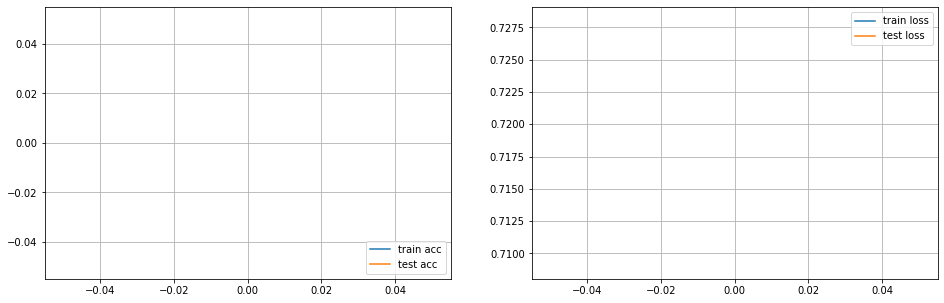

RuntimeError: CUDA out of memory. Tried to allocate 26.00 MiB (GPU 0; 15.78 GiB total capacity; 14.07 GiB already allocated; 13.75 MiB free; 14.24 GiB reserved in total by PyTorch)

In [16]:
print(gc.collect())
iterate_training()

In [ ]:
# Uncomment to load a model
# gc.collect()
# checkpoint = pt.load("./models/" + model_name + '/' + model_name)
# model.load_state_dict(checkpoint['model'])
# llayer.load_state_dict(checkpoint['llayer'])
# bcewl_loss.load_state_dict(checkpoint['bcewl_loss'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# scheduler.load_state_dict(checkpoint['scheduler'])

In [ ]:
def top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=-float('Inf')):
    """ Filter a distribution of logits using top-k and/or nucleus (top-p) filtering
        Args:
            logits: logits distribution shape (vocabulary size)
            top_k >0: keep only top k tokens with highest probability (top-k filtering).
            top_p >0.0: keep the top tokens with cumulative probability >= top_p (nucleus filtering).
                Nucleus filtering is described in Holtzman et al. (http://arxiv.org/abs/1904.09751)
    """
    assert logits.dim() == 1  # batch size 1 for now - could be updated for more but the code would be less clear
    top_k = min(top_k, logits.size(-1))  # Safety check
    if top_k > 0:
        # Remove all tokens with a probability less than the last token of the top-k
        indices_to_remove = logits < pt.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    if top_p > 0.0:
        sorted_logits, sorted_indices = pt.sort(logits, descending=True)
        cumulative_probs = pt.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

        # Remove tokens with cumulative probability above the threshold
        sorted_indices_to_remove = cumulative_probs > top_p
        # Shift the indices to the right to keep also the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        indices_to_remove = sorted_indices[sorted_indices_to_remove]
        logits[indices_to_remove] = filter_value
    return logits

In [ ]:
def append_next_token(sent, top_k=-1, top_p=0.9, temperature=1.0):
    tokens = tokenizer.encode(sent)
    x = pt.tensor([tokens])
    logits = inference(x, pt.tensor([len(tokens)]))[0]
    logits /= temperature
    logits = top_k_top_p_filtering(logits, top_k=top_k, top_p=top_p)
    probs = F.softmax(logits, dim=0)
    token = pt.multinomial(probs, 1).numpy()[0]
    tokens += [token]
    sent = tokenizer.decode(tokens)
    print(sent)
    return sent

# Interactive generation

In [ ]:
input_sentence = "A list of types of drink: coffee, water, tea, coke, lemonade, milkshake,"

In [ ]:
input_sentence = append_next_token(input_sentence, top_k=-1, top_p=0.9, temperature=1.0)